In [34]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import pandas as pd

from keras.layers import Dense
from keras.models import Sequential,Model
from scipy.stats import nakagami

from tensorflow.keras.optimizers import Adam

In [35]:
# Variables Initialization

k = 4
M = 2**k
NUM_CHANNEL_USES = 1
block_size = 320

model_training_num_of_frames = 10**3#10**4
model_validating_num_of_frames = 10**2#10**3

n_train = block_size * model_training_num_of_frames
n_val   = block_size * model_validating_num_of_frames

# Geanerating dataset
model_output_num_of_frames = 10**5
n_out = block_size * model_output_num_of_frames 

num_of_training_loops = 4
num_epoches = 10

#Definig noise standard deviation 
# We use a constant symbol (iq) rate and we assume a constance signal power of 1
"""
When the normalization_mode = 'iq' , every iq sample has the power of 1. When we are using time diversity, we use only one path to send different channel uses (symbols) for a msg.
When the normalization_mode = 'range' , the total power for all the channel uses, are 1. 
When the normalization_mode = 'msg', we normalize over all the channel uses
"""
EbNo_dB = 10#20
fs = 125*10**3
B = 2*fs*(1+0.5)*0.5     # 187500.0
Normalization_mode = 'msg' 
EbNo = 10**(EbNo_dB/10)
noise_std = (B*NUM_CHANNEL_USES/(2*fs*EbNo*k))**0.5
print(f"Noise std {noise_std}")

# Selecting channel
"""
there are three types
'awgn', 'nakagami','stochastic'
"""
channel = 'awgn'


Noise std 0.13693063937629152


In [36]:
    
class L2Normalization(tf.keras.layers.Layer):   # Normalize all the channel uses 
    def __init__(self,**kwargs):
        super(L2Normalization, self).__init__(**kwargs)
    def call(self, inputs):
        out = tf.nn.l2_normalize(inputs, axis=-1)
        print("normalize output shape = ",out.shape)
        return out
    def get_config(self):
        return super(L2Normalization, self).get_config()
    
class Normalization_layer_iq(tf.keras.layers.Layer): # Normalize iq samples (power = 1)
    def __init__(self,**kwargs):
        super(Normalization_layer_iq, self).__init__(**kwargs)
    def call(self, inputs):
        out = tf.nn.l2_normalize(tf.reshape(inputs,(-1,2)), axis=-1)
        print("normalize output shape 1 = ",out.shape)
        out = tf.reshape(out,(-1,2*NUM_CHANNEL_USES))
        print("normalize output shape 2 = ",out.shape)
        return out
    def get_config(self):
        return super(Normalization_layer_iq, self).get_config()
    

class Normalization_layer_iq_range(tf.keras.layers.Layer): # Normalize iq samples (in the range of 0.5 and 1)
    def __init__(self,**kwargs):
        super(Normalization_layer_iq_range, self).__init__(**kwargs)
    def call(self, inputs):
        out = 0.5*tf.where(inputs>0,1.0,0.0) + tf.math.sigmoid(tf.nn.relu(inputs)) - 0.5*tf.where(inputs>0,0.0,1) - tf.math.sigmoid(tf.nn.relu(-inputs))     # push the i and q values in between 0.5 and 1 and -0.5 and -1
        print("range normalize output shape 1 = ",out.shape)
        out = tf.reshape(out,(-1,2*NUM_CHANNEL_USES))
        print("range normalize output shape 2 = ",out.shape)
        return out
    def get_config(self):
        return super(Normalization_layer_iq_range, self).get_config()


def generate_nakagami_samples(m, omega):
    nakagami_amp_vec = nakagami.rvs(m,omega,size =  NUM_CHANNEL_USES)   # Same gain for the real part and the imaginary part
    nakagami_phase_vec = np.random.uniform(low=0.0, high=2*np.pi, size = NUM_CHANNEL_USES)    # phase shift will effect the complex number
    nakagami_for_real = np.reshape(nakagami_amp_vec*np.cos(nakagami_phase_vec),(-1,1))
    nakagami_for_imag = np.reshape(nakagami_amp_vec*np.sin(nakagami_phase_vec),(-1,1))
    fading_vec = np.reshape(np.concatenate((nakagami_for_real,nakagami_for_imag),axis=1),(1,-1))[0]
    return  tf.constant(fading_vec, dtype=tf.float32)
    
class NakagamiNoiseLayer(tf.keras.layers.Layer):
    def __init__(self, distribution_params, **kwargs):
        super(NakagamiNoiseLayer, self).__init__(**kwargs)
        self.distribution_params = distribution_params

    def call(self, inputs, training=False):
        if  1 or training:
            fading = generate_nakagami_samples(m = self.distribution_params["m"], 
                                              omega = self.distribution_params["omega"]) 
            return inputs * fading
        else:
            return inputs
        
class CustomNoise(tf.keras.layers.Layer):
  def __init__(self, mean=0.0, stddev=1.0, **kwargs):
    super(CustomNoise, self).__init__(**kwargs)
    self.mean = mean
    self.stddev = stddev

  def call(self, inputs):
    # Add noise regardless of training state
    noise = tf.random.normal(shape=tf.shape(inputs), mean=self.mean, stddev=self.stddev)
    return inputs + noise


In [37]:
# Making the stochasticChannelLayer

from scipy.stats import truncnorm
from scipy.stats import uniform


channel_parameters = {
    "r"        : 4,             # For upsampling -> number of complex samples per symbol
    "roll_off" : 0.35,          # Roll off factor
    "num_taps" : 31,            # L -> Number of taps (odd) for RRC filter
    "f_s"      : 25e4,          # Add what is in the physical implementation
    "T_bound"  : 1/25e4,        # 1/f_s Go through the resharch paper Deep Learning Based Communication Over the Air  (content under table 1) 
    #"time_delay" : np.random.uniform(-1,1), # To convert the time delay into discrete domain, time dilay is giving relative to the sampling period 
    "CFO"      : 5e3,           # Observe from the physical implementation
    "CFO_std"  : 5e3/25e4,      # CFO/f_s this is the normalized intersampled phase offset
    "noise_std": noise_std,     # noise power will be calculating assuming transmittting power of 1 
    "phase_off": uniform.rvs(scale = 2*np.pi)  # constant for one channel input
}


# function to create the complex values
def real_to_complex_tensor(inp_tensor):
  inp_tensor = tf.reshape(inp_tensor, [-1, 2])
  real_part = inp_tensor[:, 0]
  imag_part = inp_tensor[:, 1]
  complex_tensor = tf.complex(real_part, imag_part)
  return complex_tensor

def complex_to_real_tensor(inp_tensor):
   real_part , imag_part = tf.math.real(inp_tensor), tf.math.imag(inp_tensor)
   real_part = tf.reshape(real_part,[-1,1])
   imag_part = tf.reshape(imag_part,[-1,1])
   return tf.reshape(tf.concat([real_part,imag_part],1),[-1])

# Upsample
def upsampling(inp,r):
  com_reshape = tf.reshape(inp,[-1,1])
  padding = tf.constant([[0,0],[0,r-1]])
  upsampled = tf.pad(com_reshape,padding,"CONSTANT")
  return tf.reshape(upsampled,[-1])

# Normalized RRC with time shift
def NRRC_filter(num_taps, roll_off):
  time_delay =  np.random.uniform(-1,1), # To convert the time delay into discrete domain, time dilay is giving relative to the sampling period 
  print("time_delay - ",time_delay)
  t = np.linspace(-(num_taps-1)/2,(num_taps-1)/2,num_taps) - time_delay
  eps = np.finfo(float).eps # Small epsilon to avoid divisiomn by zero
  pi = np.pi
  def RRC_filter_coff(t):
    if abs(t) < eps:  # For t==0
      return 1.0 - roll_off + (4*roll_off/pi)
    elif roll_off != 0 and (abs(t-1/(4*roll_off))<eps or abs(t+1/(4*roll_off))<eps):
      return (roll_off/np.sqrt(2))*(1 + 2/pi)*np.sin(pi/(4*roll_off)) + (1- 2/pi)*np.cos(pi/(4*roll_off))
    else:
      nu = np.sin(pi*t*(1-roll_off)) + 4*roll_off*t*np.cos(pi*t*(1+roll_off))
      den = pi*t*(1-(4*roll_off*t)**2)
      return nu/(den + eps)
  filter_coff = np.array([RRC_filter_coff(T) for T in t])
  NRRC_filter_coff = filter_coff / np.sum(np.abs(filter_coff))
  plt.stem(t,NRRC_filter_coff)  # Plot for visualization
  plt.title(f"Time_delay = {time_delay}")
  return tf.constant(NRRC_filter_coff,dtype = tf.float32)

# Phase offset
def PhaseOffset_vec(batch_size,NUM_CHANNEL_USES,num_taps,r,CFO_std,phase_off):
  l = batch_size*r*NUM_CHANNEL_USES+num_taps-1
  CFO_off = 0.01*CFO_std#truncnorm.rvs(-1.96,1.96)*CFO_std  # CFO_min and CFO_max (boundaries) will be selected for 95% confidence
                                                             # boundaries will be selected for 95% confidence # 0.1*CFO_std
  print("CFO_off =",CFO_off)   
  print("Phase offset = ",phase_off)                                     
  exp_vec = []
  for i in range(l):
    exp_vec.append(tf.math.exp(tf.constant([0+(2*np.pi*i*CFO_off+phase_off)*1j],dtype=tf.complex64)))
  return tf.reshape(tf.stack(exp_vec),[-1])
   

class UpsamplingLayer(keras.layers.Layer):
    def __init__(self, r ):
        super().__init__()
        self.r = r
    def call(self,inputs):
       return upsampling(inputs,self.r)
    
class PulseShaping(keras.layers.Layer): 
    def __init__(self,num_taps,roll_off):
      super().__init__()
      self.nrrc_filter = NRRC_filter(num_taps,roll_off)
      self.nrrc_filter = tf.reshape(self.nrrc_filter,[num_taps,1,1])
      self.num_taps = num_taps
    def call(self, inputs):
      padding_size = self.num_taps // 2
      paddings = tf.constant([[padding_size, padding_size]])
      real_part = tf.pad(tf.math.real(inputs), paddings, "CONSTANT")
      imag_part = tf.pad(tf.math.imag(inputs), paddings, "CONSTANT")
      real_part = tf.reshape(real_part,[1,-1,1])
      imag_part = tf.reshape(imag_part,[1,-1,1])
      real_conv = tf.nn.conv1d(real_part,self.nrrc_filter,stride=1,padding="SAME")
      imag_conv = tf.nn.conv1d(imag_part,self.nrrc_filter,stride=1,padding="SAME")
      real_conv = tf.reshape(real_conv,[-1])
      imag_conv = tf.reshape(imag_conv,[-1])
      return tf.complex(real_conv,imag_conv)

class PhaseOffset(keras.layers.Layer):
    def __init__(self,batch_size,NUM_CHANNEL_USES,num_taps,r,CFO_std,phase_off):
      super().__init__()
      self.batch_size = batch_size
      self.num_channel_uses = NUM_CHANNEL_USES
      self.num_taps = num_taps
      self.r = r
      self.CFO_std = CFO_std
      self.phase_off = phase_off
    def call(self,inputs):
       return inputs * PhaseOffset_vec(self.batch_size, self.num_channel_uses,self.num_taps,self.r,self.CFO_std, self.phase_off)

class StochasticChannelLayer(keras.layers.Layer):
    """This channel will output 1D tensor.
        channel_parameters ---> custom class for parameters store
                                channel_parameters = {
                                    "r"        : 4,             # For upsampling -> number of complex samples per symbol
                                    "roll_off" : 0.35,          # Roll off factor
                                    "num_taps" : 31,            # L -> Number of taps (odd) for RRC filter
                                    "f_s"      : 25e4,          # Add what is in the physical implementation
                                    "T_bound"  : 1/25e4,        # 1/f_s Go through the resharch paper Deep Learning Based Communication Over the Air  (content under table 1) 
                                    #"time_delay" : np.random.uniform(-1,1), # To convert the time delay into discrete domain, time dilay is giving relative to the sampling period 
                                    "CFO"      : 5e3,           # Observe from the physical implementation
                                    "CFO_std"  : 5e3/25e4,      # CFO/f_s this is the normalized intersampled phase offset
                                    "noise_std": noise_std,      # noise power will be calculating assuming transmittting power of 1 
                                    "phase_off": uniform.rvs(scale = 2*np.pi)  # constant for one channel input
                                }
        r ----------> upsampling constant (number of complex samples per symbol)
        time_delay -> uniformly distributed time delay between (-1,1), discrete domain, 
                      time dilay is giving relative to the sampling period
        CFO_std ----> CFO_frequency / sampling_frequency is taken as the standared deviation
        noise_std --------> noise_std for AWGN channel
        output_shape -> None - output_shape is 1D tensor for sequence decoder, or give an output shape prefer """
    def __init__(self,name,NUM_CHANNEL_USES,batch_size,channel_parameters,**kwargs):
        super(StochasticChannelLayer,self).__init__(name=name,**kwargs)
        self.UpSamplingLayer_inst = UpsamplingLayer(channel_parameters['r'])
        self.PulseShaping_inst = PulseShaping(channel_parameters['num_taps'],channel_parameters['roll_off'])
        self.PhaseOffset_inst = PhaseOffset(batch_size,NUM_CHANNEL_USES,channel_parameters['num_taps'],channel_parameters['r'],channel_parameters['CFO_std'],channel_parameters['phase_off'])
        self.AWGNlayer = CustomNoise(mean=0.0,stddev=channel_parameters['noise_std'])#keras.layers.GaussianNoise(stddev = channel_parameters['noise_std'])
    def call(self, inputs):
      inputs = tf.reshape(inputs,[-1])
      inputs = real_to_complex_tensor(inputs)
      x = self.UpSamplingLayer_inst(inputs)
      x = self.PulseShaping_inst(x)
      x = self.PhaseOffset_inst(x)
      x = complex_to_real_tensor(x)
      x = self.AWGNlayer(x)
      #print("StochasticChannelLayer output shape = ",x.shape)
      return x
      

-------  start ----------
normalize output shape =  (None, 2)
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 16)                272       
                                                                 
 encoder_middle1 (Dense)     (None, 8)                 136       
                                                                 
 encoder_middle2 (Dense)     (None, 8)                 72        
                                                                 
 encoder_middle (Dense)      (None, 8)                 72        
                                                                 
 Encode_last_dense (Dense)   (None, 2)                 18        
                                                                 
 normalization_layer (L2Nor  (None, 2)                 0         
 malization)                                              

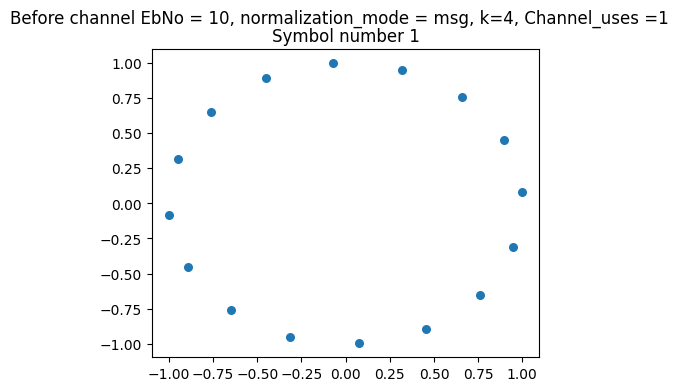

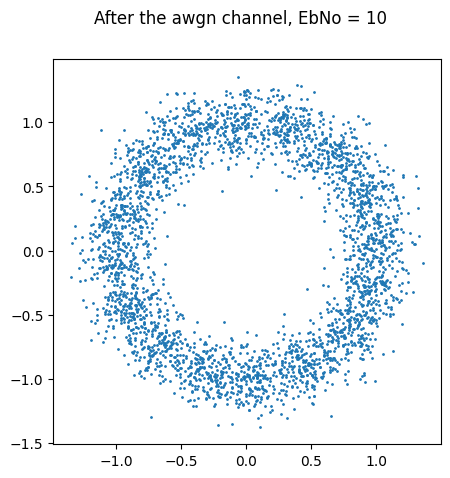

In [38]:
# Decoder mask layer

class PulseShaping_Dec(keras.layers.Layer): 
    def __init__(self,name,channel_parameters):
      super(PulseShaping_Dec,self).__init__(name=name)
      self.nrrc_filter = NRRC_filter(channel_parameters['num_taps'],channel_parameters['roll_off'])             # Will add a random time delay, but we will not be using this filter here
      self.nrrc_filter = tf.reshape(self.nrrc_filter,[channel_parameters['num_taps'],1,1])
      self.num_taps = channel_parameters['num_taps']
      self.r =channel_parameters['r']
    def call(self, inputs):
      inputs = tf.reshape(inputs,[1,-1,1])
      # a = np.zeros(channel_parameters['num_taps'])                    
      # a[15]=1
      # a = tf.reshape(tf.constant(a,dtype = tf.float32),[-1,1,1])
      # inp_conv = tf.nn.conv1d(inputs,a,stride=self.r,padding="VALID")                     # uncomment this line with above three lines to only downsample (no convolution with pulse shaping filter)
      inp_conv = tf.nn.conv1d(inputs,self.nrrc_filter,stride=self.r,padding="VALID")
      inp_conv = tf.reshape(inp_conv,[-1])
      return inp_conv


class DecoderMaskLayer(keras.layers.Layer):
    def __init__(self,name,channel_parameters,NUM_CHANNEL_USES):
        super(DecoderMaskLayer,self).__init__(name=name)
        #self.Convo = PulseShaping_Dec('Pulse_shaping_dec',channel_parameters)      # Uncomment this to have only a pulse shaping decoding filter or to only downsample
        self.Convo = tf.keras.layers.Conv1D(1,channel_parameters['num_taps'],strides=channel_parameters['r'], padding = 'valid',activation = 'relu',use_bias=True)
        self.channel_uses = NUM_CHANNEL_USES
    def call(self,inputs):
        inp = tf.reshape(inputs,[-1,2])
        real_part, imag_part = inp[:,0],inp[:,1]
        vec_shape = real_part.shape[0]
        #print("real shape",real_part.shape)
        real_part, imag_part = tf.reshape(real_part,[1,vec_shape,1]), tf.reshape(imag_part,[1,vec_shape,1])
        real_part = tf.reshape(self.Convo(real_part),[-1,1])
        imag_part = tf.reshape(self.Convo(imag_part),[-1,1])
        #print("real shape after conv ",real_part.shape)
        outputs = tf.concat([real_part,imag_part],1)
        return tf.reshape(outputs,[-1,2*self.channel_uses])
    
def calc_block_accuracy(preds,y_val):
    print("preds shape in block acc = ",preds.shape)
    block_accuracy = np.sum(np.argmax(preds,axis=1)==np.argmax(y_val,axis=1))/preds.shape[0]
    return block_accuracy

def creat_one_hot_data_set(size,k):
        x= np.zeros((size,2**k))
        indices = np.random.choice(2**k,size)
        x[np.arange(size),indices] = 1 
        return x

# complete_results = []

nakagami_m = 5 # m=1 foe reighley
OMEGA = np.sqrt(2)
AWGN_std = channel_parameters["noise_std"]

act_func = 'tanh' # 'relu'

if Normalization_mode == 'iq':
    normalization_layer = Normalization_layer_iq(name="normalization_layer")
elif Normalization_mode == 'range':
    normalization_layer = Normalization_layer_iq_range(name="normalization_layer")
elif Normalization_mode == 'msg':
    normalization_layer = L2Normalization(name="normalization_layer")

'awgn', 'nakagami','stochastic'
if channel == 'awgn':
    channel_layer = CustomNoise(mean=0.0,stddev=channel_parameters['noise_std'])
elif channel == 'nakagami':
    channel_layer = NakagamiNoiseLayer({"omega":OMEGA,"m":nakagami_m})
elif channel == 'stochastic':
    channel_layer = Sequential([
        StochasticChannelLayer("stc",NUM_CHANNEL_USES,block_size,channel_parameters), 
        DecoderMaskLayer("Decoder_mask",channel_parameters,NUM_CHANNEL_USES)
    ])

print(f"-------  start ----------")

def create_AE():
    AE = Sequential([

                    Dense(2**k, activation=act_func,input_shape=(2**k,)),
                    Dense(2**k//2, activation=act_func,name="encoder_middle1"),
                    Dense(2**k//2, activation=act_func,name="encoder_middle2"),
                    Dense(2**k//2, activation=act_func,name="encoder_middle"),
                    Dense(2*NUM_CHANNEL_USES, activation='linear',name="Encode_last_dense"),
                    #L2Normalization(name="normalization_layer"),
                    normalization_layer,
                    
                    channel_layer,
                    #StochasticChannelLayer("stc",NUM_CHANNEL_USES,block_size,channel_parameters), 

                    #NakagamiNoiseLayer({"omega":OMEGA,"m":nakagami_m}),
                    #keras.layers.GaussianNoise(stddev = AWGN_std),
    
                    #DecoderMaskLayer("Decoder_mask",channel_parameters,NUM_CHANNEL_USES),

                    Dense(2*NUM_CHANNEL_USES, activation=act_func,name="decoder_start"),
                    Dense(2**k//2, activation=act_func,name="decoder_middle1"),
                    Dense(2**k//2, activation=act_func,name="decoder_middle2"),
                    Dense(2**k//2, activation=act_func,name="decoder_middle"),
                    Dense(2**k, activation='sigmoid')

                    ])
    return AE

AE = create_AE()

AE.summary()

history = []

x_train = creat_one_hot_data_set(n_train,k)
y_train = x_train

x_val = creat_one_hot_data_set(n_val,k)
y_val = x_val

AE.compile(optimizer=Adam(learning_rate=1e-2),loss=keras.losses.categorical_crossentropy)
history.append(AE.fit(x_train,y_train,batch_size=block_size,epochs=num_epoches,verbose=2,validation_data=(x_val,y_val)))

for i in range(num_of_training_loops):
    # generating the data set

    x_train = creat_one_hot_data_set(n_train,k)
    y_train = x_train

    x_val = creat_one_hot_data_set(n_val,k)
    y_val = x_val

    AE.compile(optimizer=Adam(learning_rate=1e-3),loss=keras.losses.categorical_crossentropy)
    history.append(AE.fit(x_train,y_train,batch_size=block_size,epochs=num_epoches,verbose=2,validation_data=(x_val,y_val)))

    preds = AE.predict(x_val,batch_size=block_size)>0.5
    #         accuracy = np.mean( preds == y_val  )
    accuracy =  calc_block_accuracy(preds,y_val)
    print(f"validation accuracy = {accuracy}")
    print(f"EbNo = {EbNo_dB}")

def all_possible_k_bits_array(k):
    x = np.zeros((2**k,2**k),dtype=int)
    for i in range(2**k):
        x[i,i] = 1
    return x

before_channel = Model(inputs=AE.input,
                                 outputs=AE.get_layer('normalization_layer').output)

#x = np.array(np.random.rand(block_size,k)>0.5).astype(np.float32)
x = all_possible_k_bits_array(k)
print(x.shape)
enc=before_channel(x)
print("enc_shape = ",enc.shape)

fig, ax = plt.subplots(NUM_CHANNEL_USES,figsize =(5,4*NUM_CHANNEL_USES))
fig.suptitle(f"Before channel EbNo = {EbNo_dB}, normalization_mode = {Normalization_mode}, k={k}, Channel_uses ={NUM_CHANNEL_USES}")
if NUM_CHANNEL_USES>1:
    for i in range(NUM_CHANNEL_USES):
        enc_x , enc_y = enc[:,2*i],enc[:,2*i+1]
        ax[i].scatter(enc_x,enc_y,s=30)
        ax[i].set_title(f"Symbol number {1+i}")
else:
    enc_x , enc_y = enc[:,0],enc[:,1]
    ax.scatter(enc_x,enc_y,s=30)
    ax.set_title(f"Symbol number {1}")

channel_model =  Model(inputs=AE.get_layer('normalization_layer').output,
                                 outputs=AE.get_layer('decoder_start').input)

enc = np.repeat(enc,200,axis=0)

if channel_model=='stc':
    chan_out = channel_model.predict(enc,batch_size=block_size)#[channel_parameters['num_taps']:-channel_parameters['num_taps']]
else :
    chan_out = channel_model(enc)
chan_out = np.reshape(chan_out,(-1,2*NUM_CHANNEL_USES))


if NUM_CHANNEL_USES>1:
    fig, ax = plt.subplots(NUM_CHANNEL_USES,figsize =(5,4*NUM_CHANNEL_USES))
    fig.suptitle(f"EbNo = {EbNo_dB}dB, normalization_mode = {Normalization_mode}, k={k}, Channel_uses ={NUM_CHANNEL_USES}")
    for i in range(NUM_CHANNEL_USES):
        chan_out_x , chan_out_y = chan_out[:,2*i],chan_out[:,2*i+1]
        ax[i].scatter(chan_out_x,chan_out_y,s=1)
        ax[i].set_title(f"Symbol number ={i}, After the awgn channel, EbNo = {EbNo_dB}")
else:
    fig  = plt.figure(figsize=(5,5))
    chan_out_x , chan_out_y = np.reshape(chan_out,(-1,2))[:,0],np.reshape(chan_out,(-1,2))[:,1]
    plt.scatter(chan_out_x,chan_out_y,s=1)
    fig.suptitle(f"After the awgn channel, EbNo = {EbNo_dB}")


    


In [39]:
AE.evaluate(x_val,y_val,verbose=1)

normalize output shape =  (None, 2)
1000/1000 [==============================] - 2s 2ms/step - loss: 0.3872


0.38723623752593994